# Notebook de Modelado - Cantidad de Matrículas

En este notebook implementaremos los modelos de machine learning para generar pronósticos de la cantidad de matrículas basados en los datos procesados.

## 1. Importación de librerías

In [1]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

# Configuraciones
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


from functools import partial
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.models import AutoTBATS
from statsforecast.models import AutoARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown, Image

# Importar función de carga desde el módulo etl
from src.etl import load_dict_from_csv

from src.modelling_tools import compile_models_output, evaluate_models_metrics

from src.modelling_tools import build_X_future_step, plot_ets_decomposition, plot_residual_analysis, perform_residual_tests, forecast_with_corrected_dates, create_hybrid_forecast, plot_forecast_with_intervals, calculate_annual_variation, plot_annual_comparison, export_data, plot_histogram_boxplot

2025-10-15 00:56:48.354 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 00:56:48.364 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-15 00:56:48.364 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## 2. Carga de datos

In [2]:
# Cargar todos los datasets usando la función existente
datasets = load_dict_from_csv("data/csv", parse_dates=True)

In [3]:
# Cargar datos de cantidad de matrículas
matri = datasets["Matrícula Comerciante"]
# Ya no es necesario eliminar la última fila porque se eliminó septiembre del CSV original


In [4]:
# Renombrar columnas para el modelo
matri.rename(columns={"Fecha": "ds", "Matrícula Comerciante": "y"}, inplace=True)
matri["unique_id"] = 1

# # Comentar/descomentar si se quiere probar transformación logarítmica
# matri["y"] = np.log(matri["y"])

In [5]:
matri_x = matri.copy()

# Crear variable dummy para cambio de tarifa en enero 2025
matri_x["Cambio_tarifa"] = np.where(matri_x["ds"] >= "2025-01-01", 1, 0)

# Seleccionar columnas para el modelo (sin variables de pandemia)
cols_to_model = ["ds", "y", "unique_id", "Cambio_tarifa"]
matri_x = matri_x[cols_to_model]

# Aplicar transformación logarítmica
matri_x["y"] = np.log(matri_x["y"])

print(f"Variables en el modelo: {list(matri_x.columns)}")
print(f"Período de datos: {matri_x['ds'].min()} a {matri_x['ds'].max()}")
print(f"Total de observaciones: {len(matri_x)}")

matri_x

Variables en el modelo: ['ds', 'y', 'unique_id', 'Cambio_tarifa']
Período de datos: 2019-01-01 00:00:00 a 2025-08-01 00:00:00
Total de observaciones: 80


,ds,y,unique_id,Cambio_tarifa
0,2019-01-01,7.344,1,0
1,2019-02-01,7.286,1,0
2,2019-03-01,7.169,1,0
3,2019-04-01,7.315,1,0
4,2019-05-01,7.348,1,0
5,2019-06-01,7.162,1,0
6,2019-07-01,7.310,1,0
7,2019-08-01,7.409,1,0
8,2019-09-01,7.355,1,0
9,2019-10-01,7.284,1,0


### 2.1. Creación de Variables Exógenas de Pandemia

A continuación se crean dos variables relacionadas con el impacto de la pandemia COVID-19:

1. **pandemia_pulse**: Variable binaria que toma el valor de 1 en los períodos de choques principales:
   - **Marzo y abril de 2020**: Primer choque (más fuerte)
   - **Marzo y abril de 2021**: Segundo choque/rebrote (más suave)

2. **pandemia_adstock**: Variable que modela la **intensidad del efecto** de la pandemia (valores positivos):
   
   **Ambos choques siguen la MISMA FORMA temporal pero con diferente magnitud:**
   
   **PRIMER CHOQUE (2020 - 100% de intensidad):**
   - **Marzo 2020**: Choque inicial (0.7)
   - **Abril 2020**: Máximo impacto (1.0)
   - **Mayo 2020**: Se revierte 20% → intensidad 0.8
   - **Junio 2020**: Se revierte según recovery_pct → por defecto 95% (intensidad 0.05)
   - **Julio 2020+**: Disipación lenta
   
   **SEGUNDO CHOQUE (2021 - intensidad parametrizable, default 50%):**
   - **Marzo 2021**: Choque inicial (0.7 × shock2_intensity)
   - **Abril 2021**: Máximo impacto (1.0 × shock2_intensity)
   - **Mayo 2021**: Se revierte 20% → (0.8 × shock2_intensity)
   - **Junio 2021**: Se revierte según recovery_pct → (0.05 × shock2_intensity)
   - **Julio 2021+**: Disipación lenta
   
**Nota**: Los valores son positivos para representar la intensidad. El modelo ARIMA aprenderá si el coeficiente asociado debe ser negativo (reducción de cantidad) o positivo.

In [6]:
def create_pandemic_variables(df, date_col='ds', 
                             recovery_pct=0.80, 
                             end_period='2021-12-31',
                             include_pandemic_vars=True,
                             shock2_intensity=0.5):
    """
    Crea variables exógenas para modelar el impacto de la pandemia COVID-19.
    Incluye DOS choques con LA MISMA FORMA temporal pero diferente magnitud.
    
    Parámetros:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos de la serie temporal
    date_col : str
        Nombre de la columna de fechas (default: 'ds')
    recovery_pct : float
        Porcentaje de reversión del efecto en junio (default: 0.80, es decir, 80%)
        Se aplica a AMBOS choques
    end_period : str
        Último período en el que se disipa el efecto de la pandemia (default: '2021-12-31')
    include_pandemic_vars : bool
        Si es True, crea las variables con sus valores. Si es False, las crea con ceros (default: True)
    shock2_intensity : float
        Intensidad del segundo choque relativa al primero (default: 0.5 = 50%)
        Por ejemplo: 0.5 significa que el segundo choque es la mitad del primero
    
    Retorna:
    --------
    df : pandas.DataFrame
        DataFrame con las nuevas variables agregadas
        
    Nota:
    -----
    Las variables usan valores POSITIVOS que representan la intensidad del efecto.
    El modelo ARIMA aprenderá automáticamente si el coeficiente debe ser negativo o positivo.
    
    Ambos choques siguen LA MISMA FORMA temporal (recuperación rápida):
    
    PRIMER CHOQUE (2020):
    - Marzo: Choque inicial (0.7)
    - Abril: Máximo impacto (1.0)
    - Mayo: Se revierte 20% → queda 80% (0.8)
    - Junio: Se revierte según recovery_pct → por defecto queda 5% (0.05)
    - Julio+: Disipación lenta
    
    SEGUNDO CHOQUE (2021) - MISMA FORMA pero escalado por shock2_intensity:
    - Marzo: Choque inicial (0.7 × shock2_intensity)
    - Abril: Máximo impacto (1.0 × shock2_intensity)
    - Mayo: Se revierte 20% → queda 80% (0.8 × shock2_intensity)
    - Junio: Se revierte según recovery_pct → queda 5% (0.05 × shock2_intensity)
    - Julio+: Disipación lenta
    
    Si include_pandemic_vars=False, ambas variables se crean con valor 0 (excluye el efecto)
    """
    
    df = df.copy()
    
    # Si no se desean incluir las variables de pandemia, simplemente crear con ceros
    if not include_pandemic_vars:
        df['pandemia_pulse'] = 0
        df['pandemia_adstock'] = 0.0
        return df
    
    # 1. Crear variable pandemia_pulse (1 SOLO en marzo-abril 2020)
    df['pandemia_pulse'] = np.where(
        (df[date_col] >= '2020-03-01') & (df[date_col] <= '2020-04-30'),
        1, 0
    )
    
    # 2. Crear variable pandemia_adstock (VALORES POSITIVOS = intensidad)
    # Inicializar la variable con ceros
    df['pandemia_adstock'] = 0.0
    
    # Definir los períodos clave - PRIMER CHOQUE (2020)
    mar_2020 = pd.Timestamp('2020-03-01')
    abr_2020 = pd.Timestamp('2020-04-01')
    may_2020 = pd.Timestamp('2020-05-01')
    jun_2020 = pd.Timestamp('2020-06-01')
    
    # Definir los períodos clave - SEGUNDO CHOQUE (2021) - MISMA FORMA
    mar_2021 = pd.Timestamp('2021-03-01')
    abr_2021 = pd.Timestamp('2021-04-01')
    may_2021 = pd.Timestamp('2021-05-01')
    jun_2021 = pd.Timestamp('2021-06-01')
    
    end_date = pd.Timestamp(end_period)
    
    # Calcular el efecto adstock para cada fila
    for idx, row in df.iterrows():
        fecha = row[date_col]
        
        # ==================== PRIMER CHOQUE 2020 (intensidad = 1.0) ====================
        if fecha == mar_2020:
            df.at[idx, 'pandemia_adstock'] = 0.2
            
        elif fecha == abr_2020:
            df.at[idx, 'pandemia_adstock'] = 1.0
            
        elif fecha == may_2020:
            df.at[idx, 'pandemia_adstock'] = 0.3
            
        elif fecha == jun_2020:
            df.at[idx, 'pandemia_adstock'] = 1.0 * (1 - recovery_pct)
            
        elif fecha > jun_2020 and fecha < mar_2021:
            # Julio 2020 - Febrero 2021: disipación lenta del primer choque
            meses_desde_junio = (fecha.year - jun_2020.year) * 12 + (fecha.month - jun_2020.month)
            meses_hasta_mar2021 = (mar_2021.year - jun_2020.year) * 12 + (mar_2021.month - jun_2020.month)
            
            valor_junio = 1.0 * (1 - recovery_pct)
            decay_rate = 2.5 / meses_hasta_mar2021
            efecto_restante = valor_junio * np.exp(-decay_rate * meses_desde_junio)
            
            df.at[idx, 'pandemia_adstock'] = efecto_restante
        
        # ==================== SEGUNDO CHOQUE 2021 (MISMA FORMA × shock2_intensity) ====================
        elif fecha == mar_2021:
            # Marzo 2021: choque inicial escalado
            df.at[idx, 'pandemia_adstock'] = 0.3 * shock2_intensity
            
        elif fecha == abr_2021:
            # Abril 2021: máximo impacto escalado
            df.at[idx, 'pandemia_adstock'] = 1.0 * shock2_intensity
            
        elif fecha == may_2021:
            # Mayo 2021: se revierte 20% (queda 80%) escalado
            df.at[idx, 'pandemia_adstock'] = 0.5 * shock2_intensity
            
        elif fecha == jun_2021:
            # Junio 2021: reversión según recovery_pct, escalado
            df.at[idx, 'pandemia_adstock'] = (1.0 * (1 - recovery_pct)) * shock2_intensity
            
        elif fecha > jun_2021 and fecha <= end_date:
            # Julio 2021 en adelante: disipación lenta escalada
            meses_desde_junio21 = (fecha.year - jun_2021.year) * 12 + (fecha.month - jun_2021.month)
            meses_totales = (end_date.year - jun_2021.year) * 12 + (end_date.month - jun_2021.month)
            
            if meses_totales > 0:
                valor_junio21 = (1.0 * (1 - recovery_pct)) * shock2_intensity
                decay_rate = 3.0 / meses_totales
                efecto_restante = valor_junio21 * np.exp(-decay_rate * meses_desde_junio21)
                df.at[idx, 'pandemia_adstock'] = efecto_restante
    
    return df


# Aplicar la función al DataFrame
# IMPORTANTE: Cambiar include_pandemic_vars=False para excluir las variables de pandemia
# Definir parámetros como variables para poder referenciarlos después
shock2_intensity = 0  # 🔇 SEGUNDO CHOQUE SILENCIADO (cambiar a 1/4, 1/3, etc. para activar)

matri_x = create_pandemic_variables(
    matri_x, 
    date_col='ds',
    recovery_pct=0.95,          # 95% de reversión en junio (para AMBOS choques)
    end_period='2022-12-31',    # Efecto se disipa completamente al final de 2022
    include_pandemic_vars=True, # ⚠️ Cambiar a False para excluir variables de pandemia
    shock2_intensity=shock2_intensity
)

# Actualizar la lista de columnas para el modelo
cols_to_model = ["ds", "y", "unique_id", "Cambio_tarifa", "pandemia_pulse", "pandemia_adstock"]
matri_x = matri_x[cols_to_model]

print(f"Variables en el modelo: {list(matri_x.columns)}")
print(f"\n✅ VARIABLES DE PANDEMIA CREADAS (DOS CHOQUES - MISMA FORMA)")
print("=" * 70)

# Verificar si las variables están activas o desactivadas
if matri_x['pandemia_pulse'].sum() == 0 and matri_x['pandemia_adstock'].sum() == 0:
    print("⚠️  VARIABLES DE PANDEMIA DESACTIVADAS (todos los valores = 0)")
    print("    Las variables existen en el dataset pero no tienen efecto en el modelo")
else:
    print("✅ VARIABLES DE PANDEMIA ACTIVAS (DOS choques con MISMA FORMA temporal)")
    print(f"   Segundo choque = {shock2_intensity*100:.0f}% del primero")
    print(f"\nEstadísticas de pandemia_pulse:")
    print(f"  Total de períodos con pulse = 1: {matri_x['pandemia_pulse'].sum():.0f}")
    pulse_2020 = matri_x[(matri_x['ds'] >= '2020-03-01') & (matri_x['ds'] <= '2020-04-30') & (matri_x['pandemia_pulse'] == 1)]
    pulse_2021 = matri_x[(matri_x['ds'] >= '2021-03-01') & (matri_x['ds'] <= '2021-04-30') & (matri_x['pandemia_pulse'] == 1)]
    print(f"  Períodos primer choque (Mar-Abr 2020): {len(pulse_2020)} meses")
    print(f"  Períodos segundo choque (Mar-Abr 2021): {len(pulse_2021)} meses")

    print(f"\nEstadísticas de pandemia_adstock (intensidad):")
    print(f"  Valor mínimo: {matri_x['pandemia_adstock'].min():.4f}")
    print(f"  Valor máximo (máxima intensidad): {matri_x['pandemia_adstock'].max():.4f}")
    print(f"  Períodos con efecto adstock > 0: {(matri_x['pandemia_adstock'] > 0).sum()}")

    # Mostrar valores del primer choque
    print(f"\n📊 PRIMER CHOQUE (2020 - 100% intensidad):")
    adstock_2020 = matri_x[(matri_x['ds'] >= '2020-03-01') & (matri_x['ds'] <= '2020-07-31')]
    print(adstock_2020[adstock_2020['pandemia_adstock'] > 0][['ds', 'pandemia_adstock']].head(6))
    
    # Mostrar valores del segundo choque
    print(f"\n📊 SEGUNDO CHOQUE (2021 - {shock2_intensity*100:.0f}% intensidad, misma forma):")
    adstock_2021 = matri_x[(matri_x['ds'] >= '2021-03-01') & (matri_x['ds'] <= '2021-07-31')]
    print(adstock_2021[adstock_2021['pandemia_adstock'] > 0][['ds', 'pandemia_adstock']].head(6))

    print("\n💡 INTERPRETACIÓN (MISMA FORMA, DIFERENTE MAGNITUD):")
    print(f"   PRIMER CHOQUE (2020 - 100%):")
    print(f"   - Marzo 2020: 0.70  |  Abril 2020: 1.00  |  Mayo 2020: 0.80  |  Junio 2020: 0.05")
    print(f"")
    print(f"   SEGUNDO CHOQUE (2021 - {shock2_intensity*100:.0f}%):")
    print(f"   - Marzo 2021: {0.7*shock2_intensity:.2f}  |  Abril 2021: {1.0*shock2_intensity:.2f}  |  Mayo 2021: {0.8*shock2_intensity:.2f}  |  Junio 2021: {0.05*shock2_intensity:.3f}")
    print(f"")
    print("   - Ambos choques siguen el mismo patrón de recuperación rápida")
    print("   - El modelo ARIMA estimará si el coeficiente es negativo o positivo")
    print("   - Se espera que el coeficiente sea NEGATIVO (reduce cantidad de matrículas)")

print("=" * 70)

Variables en el modelo: ['ds', 'y', 'unique_id', 'Cambio_tarifa', 'pandemia_pulse', 'pandemia_adstock']

✅ VARIABLES DE PANDEMIA CREADAS (DOS CHOQUES - MISMA FORMA)
✅ VARIABLES DE PANDEMIA ACTIVAS (DOS choques con MISMA FORMA temporal)
   Segundo choque = 0% del primero

Estadísticas de pandemia_pulse:
  Total de períodos con pulse = 1: 2
  Períodos primer choque (Mar-Abr 2020): 2 meses
  Períodos segundo choque (Mar-Abr 2021): 0 meses

Estadísticas de pandemia_adstock (intensidad):
  Valor mínimo: 0.0000
  Valor máximo (máxima intensidad): 1.0000
  Períodos con efecto adstock > 0: 12

📊 PRIMER CHOQUE (2020 - 100% intensidad):
           ds  pandemia_adstock
14 2020-03-01             0.200
15 2020-04-01             1.000
16 2020-05-01             0.300
17 2020-06-01             0.050
18 2020-07-01             0.038

📊 SEGUNDO CHOQUE (2021 - 0% intensidad, misma forma):
Empty DataFrame
Columns: [ds, pandemia_adstock]
Index: []

💡 INTERPRETACIÓN (MISMA FORMA, DIFERENTE MAGNITUD):
   PRIM

In [7]:
matri_x

,ds,y,unique_id,Cambio_tarifa,pandemia_pulse,pandemia_adstock
0,2019-01-01,7.344,1,0,0,0.000
1,2019-02-01,7.286,1,0,0,0.000
2,2019-03-01,7.169,1,0,0,0.000
3,2019-04-01,7.315,1,0,0,0.000
4,2019-05-01,7.348,1,0,0,0.000
5,2019-06-01,7.162,1,0,0,0.000
6,2019-07-01,7.310,1,0,0,0.000
7,2019-08-01,7.409,1,0,0,0.000
8,2019-09-01,7.355,1,0,0,0.000
9,2019-10-01,7.284,1,0,0,0.000


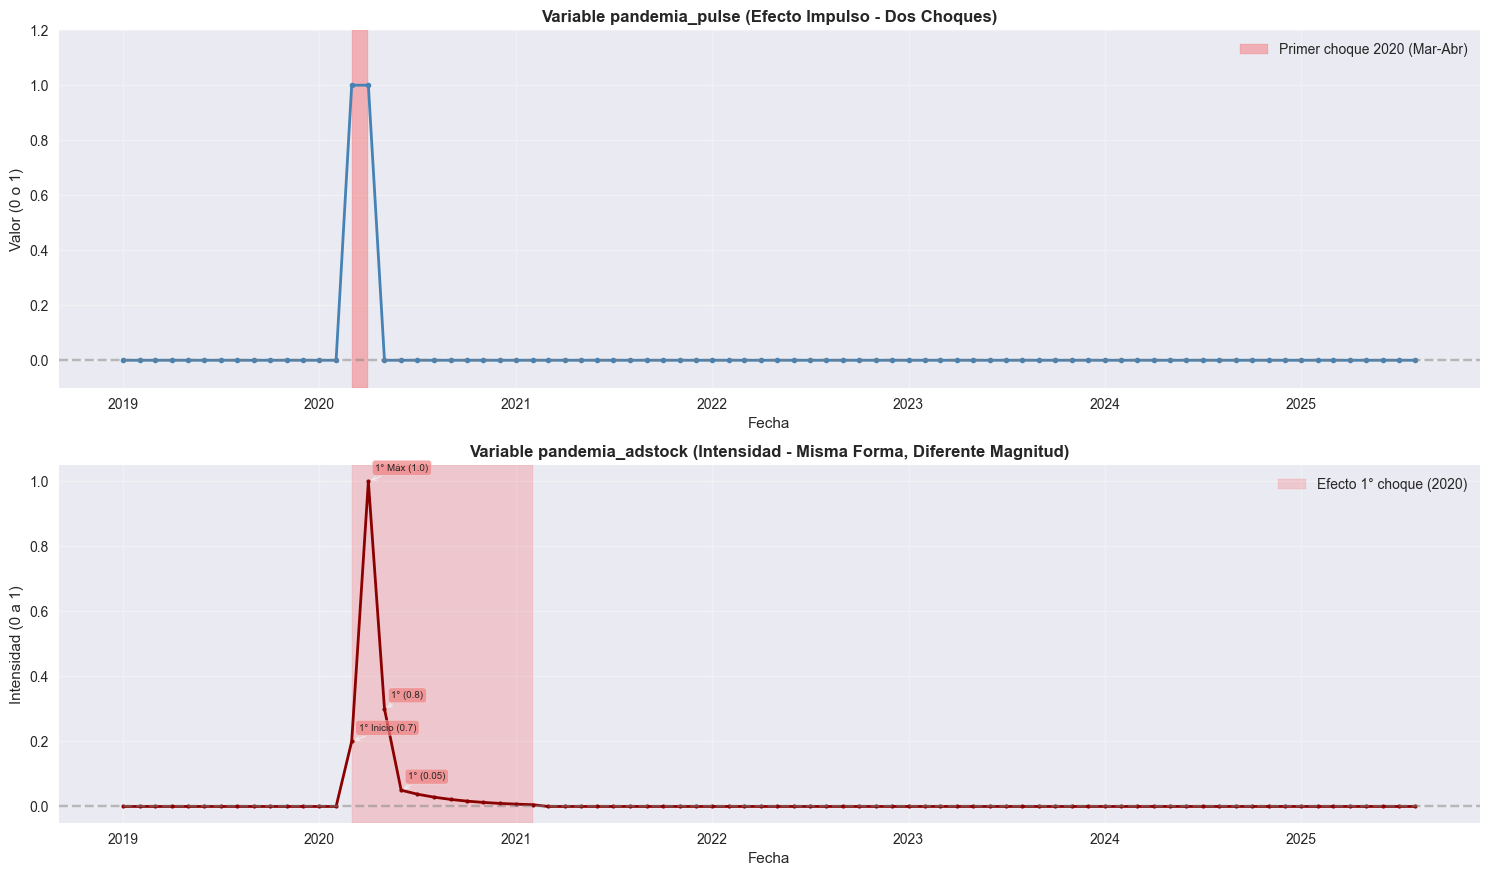

In [8]:
# Visualizar las variables de pandemia (DOS choques - MISMA FORMA)
fig, axes = plt.subplots(2, 1, figsize=(15, 9))

# Gráfico 1: pandemia_pulse
axes[0].plot(matri_x['ds'], matri_x['pandemia_pulse'], marker='o', linestyle='-', linewidth=2, markersize=4, color='steelblue')
axes[0].set_title('Variable pandemia_pulse (Efecto Impulso - Dos Choques)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor (0 o 1)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylim(-0.1, 1.2)

# Resaltar los períodos de pulse (Mar-Abr para AMBOS años)
pulse_dates_2020 = matri_x[(matri_x['ds'] >= '2020-03-01') & (matri_x['ds'] <= '2020-04-30') & (matri_x['pandemia_pulse'] == 1)]['ds']
pulse_dates_2021 = matri_x[(matri_x['ds'] >= '2021-03-01') & (matri_x['ds'] <= '2021-04-30') & (matri_x['pandemia_pulse'] == 1)]['ds']

if len(pulse_dates_2020) > 0:
    axes[0].axvspan(pulse_dates_2020.min(), pulse_dates_2020.max(), alpha=0.25, color='red', label='Primer choque 2020 (Mar-Abr)')
if len(pulse_dates_2021) > 0:
    axes[0].axvspan(pulse_dates_2021.min(), pulse_dates_2021.max(), alpha=0.25, color='orange', label='Segundo choque 2021 (Mar-Abr)')
axes[0].legend()

# Gráfico 2: pandemia_adstock (DOS choques - MISMA FORMA)
axes[1].plot(matri_x['ds'], matri_x['pandemia_adstock'], marker='o', linestyle='-', linewidth=2, markersize=3, color='darkred')
axes[1].set_title('Variable pandemia_adstock (Intensidad - Misma Forma, Diferente Magnitud)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Intensidad (0 a 1)')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Resaltar los períodos de efecto adstock
adstock_dates_2020 = matri_x[(matri_x['ds'] >= '2020-03-01') & (matri_x['ds'] <= '2021-02-28') & (matri_x['pandemia_adstock'] > 0)]['ds']
adstock_dates_2021 = matri_x[(matri_x['ds'] >= '2021-03-01') & (matri_x['ds'] <= '2022-12-31') & (matri_x['pandemia_adstock'] > 0)]['ds']

if len(adstock_dates_2020) > 0:
    axes[1].axvspan(adstock_dates_2020.min(), adstock_dates_2020.max(), alpha=0.15, color='red', label='Efecto 1° choque (2020)')
if len(adstock_dates_2021) > 0:
    axes[1].axvspan(adstock_dates_2021.min(), adstock_dates_2021.max(), alpha=0.15, color='orange', label='Efecto 2° choque (2021)')
axes[1].legend()

# Agregar anotaciones en puntos clave - PRIMER CHOQUE (2020)
key_dates_2020 = {
    '2020-03-01': '1° Inicio (0.7)',
    '2020-04-01': '1° Máx (1.0)',
    '2020-05-01': '1° (0.8)',
    '2020-06-01': '1° (0.05)'
}

for date_str, label in key_dates_2020.items():
    date = pd.Timestamp(date_str)
    if date in matri_x['ds'].values:
        value = matri_x[matri_x['ds'] == date]['pandemia_adstock'].values[0]
        axes[1].annotate(label, xy=(date, value), xytext=(5, 8), 
                        textcoords='offset points', fontsize=7,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=0.8))

# Agregar anotaciones en puntos clave - SEGUNDO CHOQUE (2021)
# Usar el valor de shock2_intensity definido anteriormente
key_dates_2021 = {
    '2021-03-01': f'2° Inicio ({0.7*shock2_intensity:.2f})',
    '2021-04-01': f'2° Máx ({1.0*shock2_intensity:.2f})',
    '2021-05-01': f'2° ({0.8*shock2_intensity:.2f})',
    '2021-06-01': f'2° ({0.05*shock2_intensity:.3f})'
}

for date_str, label in key_dates_2021.items():
    date = pd.Timestamp(date_str)
    if date in matri_x['ds'].values:
        value = matri_x[matri_x['ds'] == date]['pandemia_adstock'].values[0]
        if value > 0:  # Solo anotar si hay valor
            axes[1].annotate(label, xy=(date, value), xytext=(5, 8), 
                            textcoords='offset points', fontsize=7,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.7),
                            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=0.8))



plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()

📊 ESTADÍSTICAS DESCRIPTIVAS
N observaciones: 80
Media: 1308.08 | Mediana: 1324.00
Desv. Estándar: 321.37
Q1: 1161.75 | Q3: 1530.25 | IQR: 368.50
Min: 88.00 | Max: 1994.00
Outliers: 3 (3.8%)


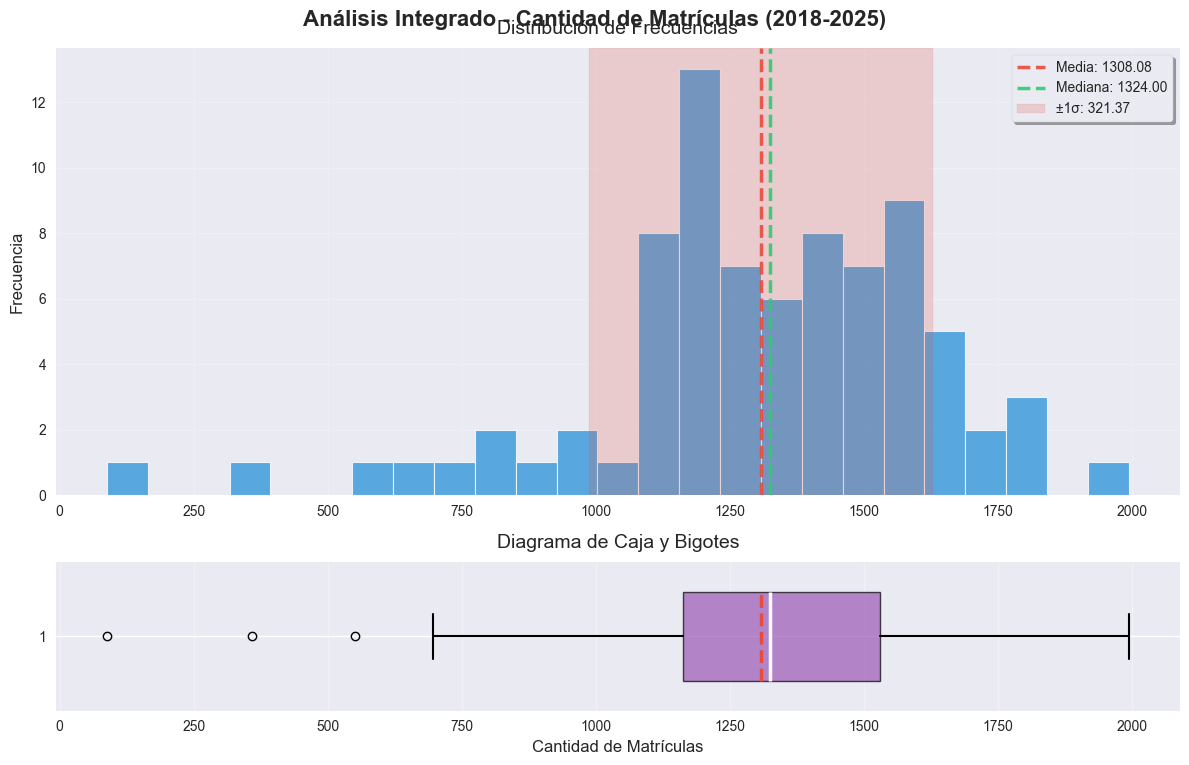

In [9]:
# Análisis visual de la distribución - datos originales
fig, axes = plot_histogram_boxplot(
    df=matri, 
    column='y', 
    title='Análisis Integrado - Cantidad de Matrículas (2018-2025)',
    xlabel='Cantidad de Matrículas',
    ylabel='Frecuencia',
    bins=25,
    figsize=(12, 8),
    layout='vertical'  # Histograma arriba, boxplot abajo (más integrado)
)

plt.show()

📊 ESTADÍSTICAS DESCRIPTIVAS
N observaciones: 80
Media: 7.12 | Mediana: 7.19
Desv. Estándar: 0.40
Q1: 7.06 | Q3: 7.33 | IQR: 0.28
Min: 4.48 | Max: 7.60
Outliers: 5 (6.2%)


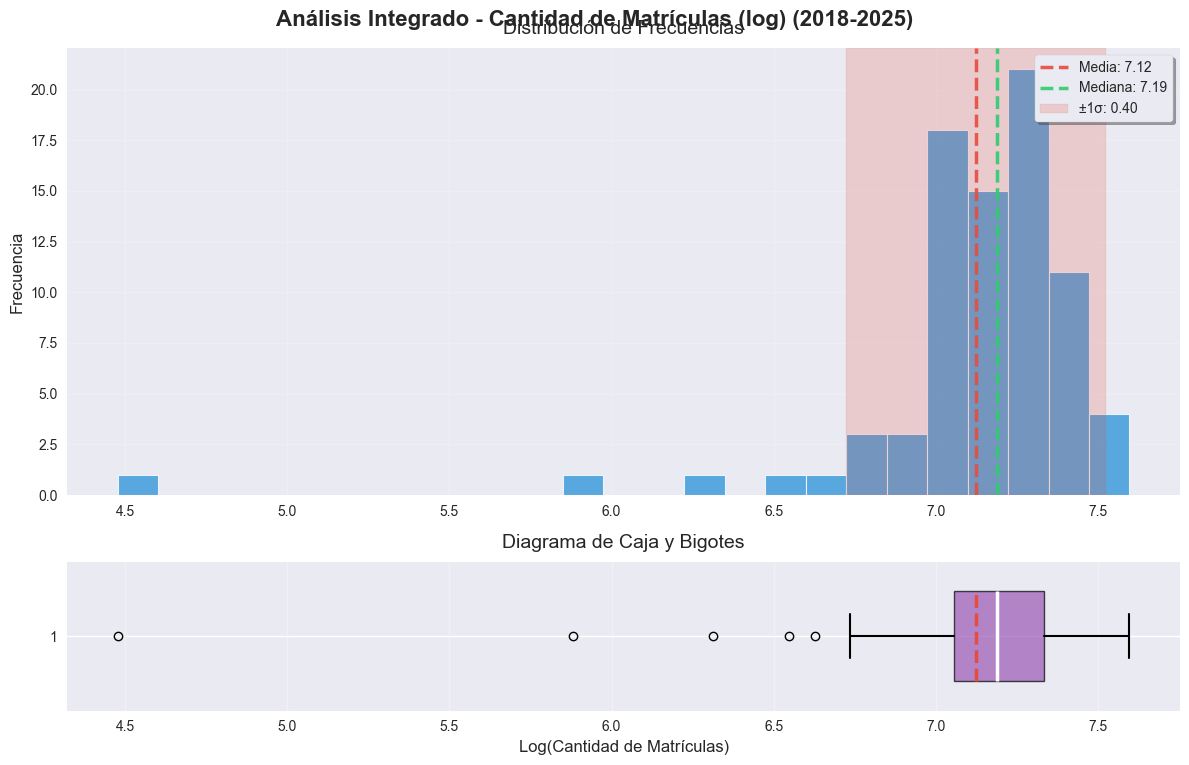

In [10]:
# Análisis visual de la distribución - datos transformados (log)
fig, axes = plot_histogram_boxplot(
    df=matri_x, 
    column='y', 
    title='Análisis Integrado - Cantidad de Matrículas (log) (2018-2025)',
    xlabel='Log(Cantidad de Matrículas)',
    ylabel='Frecuencia',
    bins=25,
    figsize=(12, 8),
    layout='vertical'  # Histograma arriba, boxplot abajo (más integrado)
)

plt.show()

# 3. Modelación

In [11]:
import pandas as pd

from statsforecast import StatsForecast
from statsforecast.models import AutoETS

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape

## Con exógenas

### Model config

In [12]:
import inspect
from utilsforecast.evaluation import evaluate
print(inspect.signature(evaluate))
# ---------------------------
# Config
# ---------------------------

H = 16  # forecast horizon = 16 months (de septiembre 2025 a diciembre 2026)
models = [
    # ARIMA FAMILY
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),

]

(df: ~AnyDFType, metrics: List[Callable], models: Optional[List[str]] = None, train_df: Optional[~AnyDFType] = None, level: Optional[List[int]] = None, id_col: str = 'unique_id', time_col: str = 'ds', target_col: str = 'y', agg_fn: Optional[str] = None) -> ~AnyDFType


### Model Fitting

In [13]:
sf = StatsForecast(models=models, freq="M")

sf = sf.fit(
    df=matri_x,
    target_col="y",
)

# Crear X_future con valores específicos para las variables exógenas
X_future = build_X_future_step(
    matri_x, 
    H, 
    freq='M', 
    exog_values={
        'Cambio_tarifa': 1,      # Suponemos que el cambio tarifario continúa
        'pandemia_pulse': 0,     # No hay efecto de pulse en el futuro
        'pandemia_adstock': 0,   # No hay efecto de adstock en el futuro
    })
          

# Generar pronósticos con variables exógenas usando la función wrapper
fc = forecast_with_corrected_dates(sf, df=matri_x, h=H, level=[90, 95], fitted=True, X_df=X_future, freq='M')

pronostico_auto_arima_x = fc.copy()

# Obtener valores ajustados para análisis posterior
fitted_values = sf.forecast_fitted_values()
models_dict = compile_models_output(fitted_values)

### Model Evaluation

In [14]:
# Evaluar modelos con métricas (RMSE, MAE, MAPE)
metrics_results = evaluate_models_metrics(models_dict)
pd.set_option('display.float_format', '{:.2f}'.format)
metrics_results

,model,rmse,mae,mape
0,auto,0.12,0.09,1.28


### Residuals check

##### Sarimax model

In [15]:
# Importar librerías necesarias para análisis de residuales
import scipy.stats as stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox  # Importación correcta para ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import numpy as np


fitted_best_model_02 = sf.fitted_[0,0].model_
# Extraer residuales
residuales_2 = fitted_best_model_02["residuals"]
fitted_val_2 = models_dict["auto"]["fitted"].values
# Calcular valores ajustados correctamente
original_values_2 = matri["y"].values


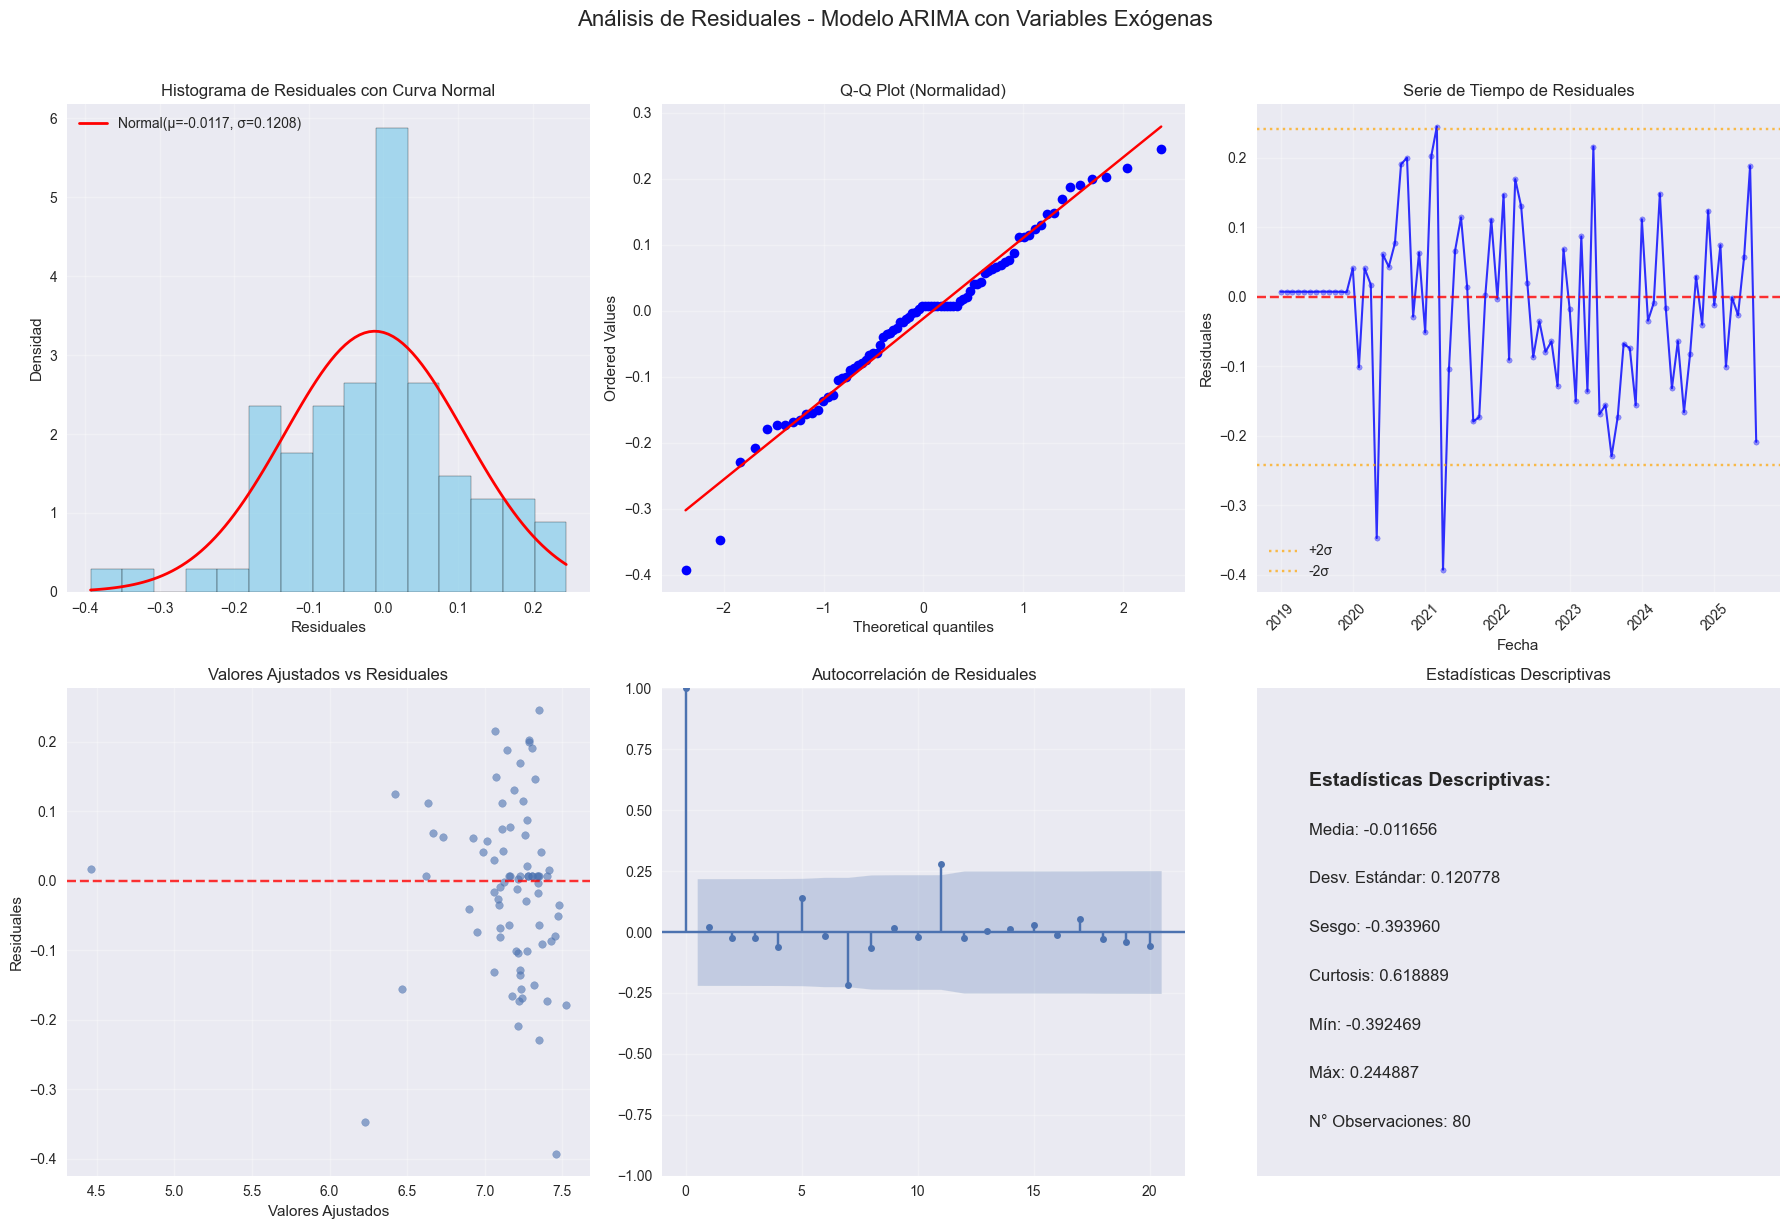

In [16]:
# Crear análisis gráfico de residuales para el modelo ARIMA con variables exógenas
fig, axes = plot_residual_analysis(
    residuals=residuales_2,
    fitted_values=fitted_val_2,
    title="Análisis de Residuales - Modelo ARIMA con Variables Exógenas",
    bins=15,
    lags=20,
    dates=matri_x["ds"]  # Agregar las fechas para el eje x del gráfico temporal
)
plt.show()

In [17]:
# Análisis de residuales del modelo ARIMA
results_arima = perform_residual_tests(
    residuals=residuales_2,
    title="Análisis Estadístico de Residuales - Modelo ARIMA con Variables Exógenas",
    alpha=0.05
)

ANÁLISIS ESTADÍSTICO DE RESIDUALES - MODELO ARIMA CON VARIABLES EXÓGENAS

1. PRUEBAS DE NORMALIDAD:
------------------------------
Shapiro-Wilk Test:
   Estadístico: 0.975875
   p-valor: 0.134558
   Conclusión: No se rechaza normalidad

Jarque-Bera Test:
   Estadístico: 3.346140
   p-valor: 0.187670
   Sesgo: -0.393960
   Curtosis: 3.618889
   Conclusión: No se rechaza normalidad

Anderson-Darling Test:
   Estadístico: 0.580384
   Valor crítico (5%): 0.752000
   Conclusión: No se rechaza normalidad


2. PRUEBAS DE AUTOCORRELACIÓN:
------------------------------
Ljung-Box Test (lag 10):
   Estadístico: 6.850829
   p-valor: 0.739449
   Conclusión: No hay autocorrelación significativa

Durbin-Watson Test:
   Estadístico: 1.903710
   Interpretación: Sin autocorrelación fuerte


3. PRUEBAS DE HOMOCEDASTICIDAD:
------------------------------
Breusch-Pagan Test:
   Estadístico LM: 0.078057
   p-valor: 0.779948
   Estadístico F: 0.076180
   p-valor F: 0.783273
   Conclusión: No hay heterocedas

# Forecast

**Observaciones**

- Para este modelo actualizado, utilizamos datos desde 2018 en adelante, capturando todo el período histórico disponible incluyendo el efecto de la pandemia.

- Se modela un enfoque con variables exógenas: 
  1. **Modelo ARIMA con variables exógenas**: Incluye las variables `Cambio_tarifa`, `pandemia_pulse` y `pandemia_adstock` para capturar:
     - El efecto del incremento tarifario a partir de enero 2025
     - Los choques de la pandemia (2020 y 2021)
     - La recuperación gradual post-pandemia

- Al incluir las variables relacionadas con la pandemia, el modelo puede aprender de todo el comportamiento histórico de la serie, lo que proporciona pronósticos más robustos que consideran eventos extraordinarios pasados.

### 

(<Figure size 1400x800 with 1 Axes>,
 <Axes: title={'center': 'Pronóstico SARIMAX con variables de pandemia (datos desde 2018) - Cantidad de Matrículas'}, xlabel='Fecha', ylabel='Cantidad de Matrículas (log)'>)

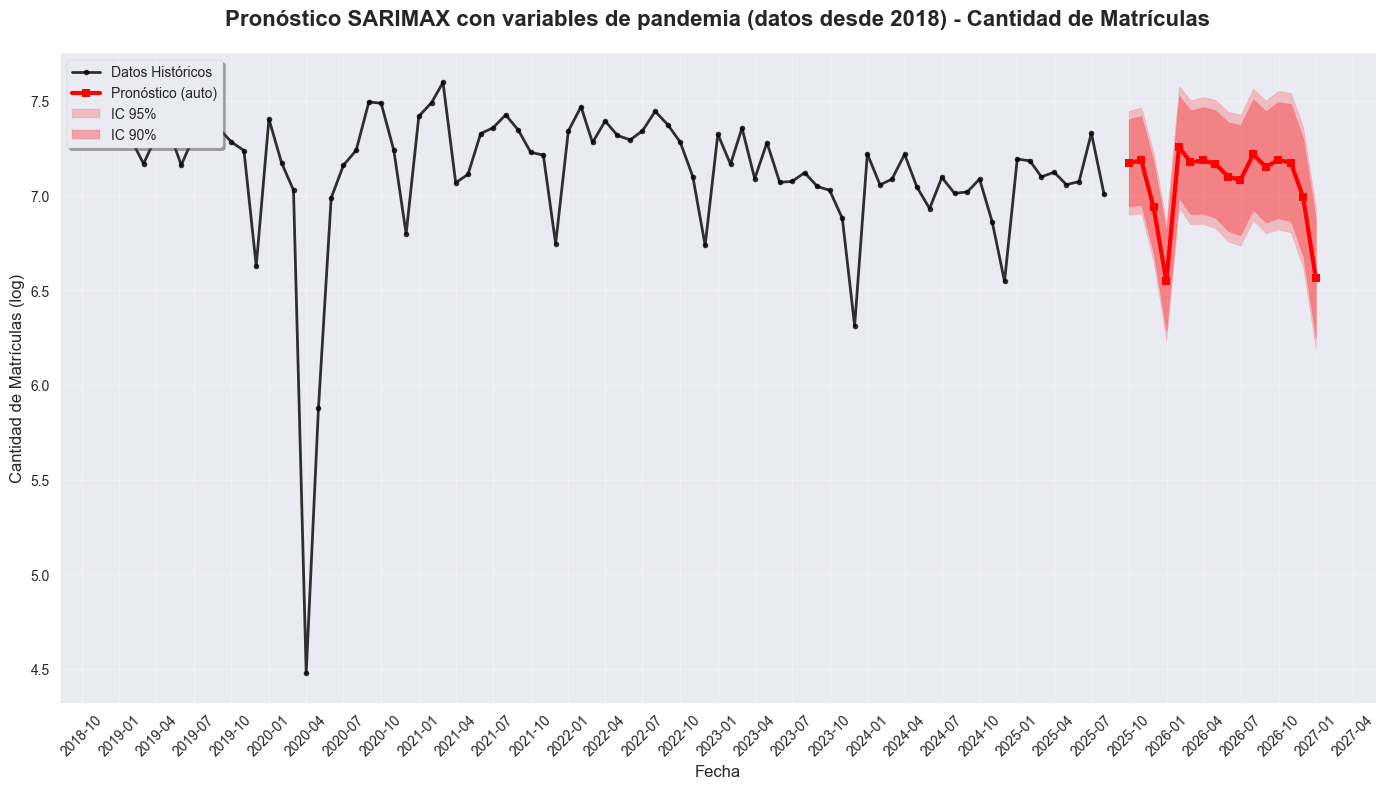

In [18]:
# Visualizar el pronóstico con intervalos de confianza usando la nueva función
plot_forecast_with_intervals(
    historical_data=matri_x,
    forecast_data=pronostico_auto_arima_x,
    main_col='auto',  
    ds_col='ds', 
    y_col='y',
    title='Pronóstico SARIMAX con variables de pandemia (datos desde 2018) - Cantidad de Matrículas',
    y_label='Cantidad de Matrículas (log)',
    figsize=(14, 8)
)

## Análisis de Variación Esperada para 2026

In [19]:
# Convertir de logaritmo a valores reales (aplicar exponencial inversa)
# Crear una copia para no modificar el DataFrame original
pronostico_auto_arima_x_real = pronostico_auto_arima_x.copy()

# Identificar columnas numéricas (excluir 'ds' y 'unique_id')
columnas_numericas = pronostico_auto_arima_x_real.select_dtypes(include=[np.number]).columns.tolist()
columnas_a_convertir = [col for col in columnas_numericas if col not in ['unique_id']]

print(f"Columnas a convertir de log a valores reales: {columnas_a_convertir}")

# Aplicar transformación exponencial (inversa del logaritmo natural np.log)
for col in columnas_a_convertir:
    pronostico_auto_arima_x_real[col] = np.exp(pronostico_auto_arima_x_real[col])

print(f"\n📊 Transformación completada: {len(columnas_a_convertir)} columnas convertidas de log natural a valores reales")
print(f"📈 Los valores ahora están en la escala original (cantidad de matrículas)")

pronostico_auto_arima_x_real

Columnas a convertir de log a valores reales: ['auto', 'auto-lo-95', 'auto-lo-90', 'auto-hi-90', 'auto-hi-95']

📊 Transformación completada: 5 columnas convertidas de log natural a valores reales
📈 Los valores ahora están en la escala original (cantidad de matrículas)


,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,1304.23,991.66,1036.32,1641.42,1715.34
1,1,2025-10-31,1320.32,997.01,1043.07,1671.27,1748.46
2,1,2025-11-30,1030.47,772.31,808.96,1312.64,1374.93
3,1,2025-12-31,697.67,508.94,535.42,909.09,956.37
4,1,2026-01-31,1418.65,1028.85,1083.39,1857.65,1956.12
5,1,2026-02-28,1307.63,942.63,993.56,1720.99,1813.97
6,1,2026-03-31,1320.71,944.37,996.69,1750.07,1847.04
7,1,2026-04-30,1295.46,922.60,974.34,1722.40,1819.01
8,1,2026-05-31,1212.48,860.50,909.28,1616.79,1708.42
9,1,2026-06-30,1189.79,841.60,889.78,1590.98,1682.05


In [20]:
# CÁLCULO CORRECTO DE VARIACIÓN ANUAL 2025 vs 2026
# ===============================================================

# Definir una variable para pronosticos_temp si no existe
pronosticos_temp = pronostico_auto_arima_x_real.copy()
pronosticos_temp = pronostico_auto_arima_x_real.rename(columns={'Fecha': 'ds'})

# ✅ CORRECCIÓN: Filtrar datos históricos hasta agosto 2025 solamente (para coincidir con Streamlit)
matri_corregido = matri[matri["ds"] <= "2025-08-31"].copy()
print(f"📊 Datos históricos corregidos hasta: {matri_corregido['ds'].max()}")
print(f"📊 Total de observaciones históricas: {len(matri_corregido)}")

# Paso 1: Calcular el total proyectado completo de 2025
# -------------------------------------------------------
# Total histórico 2025 (enero-agosto, datos reales) - CORREGIDO
total_2025_historico = matri_corregido[matri_corregido["ds"] >= "2025-01-01"]["y"].sum()
print(f"📊 Total 2025 histórico (ene-ago): {total_2025_historico:,.0f} matrículas")

# Pronósticos para completar 2025 (septiembre-diciembre) - CORREGIDO
pronosticos_2025_restante = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2025-09-01") & 
    (pronosticos_temp["ds"] <= "2025-12-31")
]["auto"].sum()
print(f"📊 Pronósticos 2025 restantes (sep-dic): {pronosticos_2025_restante:,.0f} matrículas")

# Total 2025 proyectado completo
total_2025_completo = total_2025_historico + pronosticos_2025_restante
print(f"📊 Total 2025 proyectado completo: {total_2025_completo:,.0f} matrículas")

# Paso 2: Calcular el total proyectado de 2026
# ----------------------------------------------
total_2026_proyectado = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2026-01-01") & 
    (pronosticos_temp["ds"] <= "2026-12-31")
]["auto"].sum()
print(f"📊 Total 2026 proyectado: {total_2026_proyectado:,.0f} matrículas")

# Paso 3: Calcular la variación real
# -----------------------------------
variacion_absoluta = total_2026_proyectado - total_2025_completo
variacion_porcentual = (variacion_absoluta / total_2025_completo) * 100

print(f"\n🎯 ANÁLISIS DE VARIACIÓN ANUAL CORREGIDO")
print("=" * 50)
print(f"Total 2025 (Proyección completa): {total_2025_completo:,.0f} matrículas")
print(f"Total 2026 (Pronóstico):          {total_2026_proyectado:,.0f} matrículas")
print(f"Variación Absoluta:               {variacion_absoluta:+,.0f} matrículas")
print(f"VARIACIÓN PORCENTUAL:             {variacion_porcentual:+.2f}%")
print("=" * 50)

# Guardar los resultados corregidos con las claves que espera plot_annual_comparison
results_corrected = {
    'total_2025_historico': total_2025_historico,
    'total_2025_pronosticos_restantes': pronosticos_2025_restante,
    'total_2025_completo': total_2025_completo,
    'total_2026_proyectado': total_2026_proyectado,
    'variacion_absoluta': variacion_absoluta,
    'variacion_porcentual': variacion_porcentual,
    # Agregar las claves que espera la función plot_annual_comparison
    'base_year': 2025,
    'target_year': 2026,
    'total_base_year': total_2025_completo,
    'total_target_year': total_2026_proyectado,
    'absolute_variation': variacion_absoluta,
    'percentage_variation': variacion_porcentual
}

print(f"\n✅ VERIFICACIÓN CON STREAMLIT:")
print(f"📊 Datos históricos 2025 (notebook corregido): {total_2025_historico:,.0f} matrículas")
print(f"✅ Ahora ambos cálculos deberían coincidir")

📊 Datos históricos corregidos hasta: 2025-08-01 00:00:00
📊 Total de observaciones históricas: 80
📊 Total 2025 histórico (ene-ago): 10,073 matrículas
📊 Pronósticos 2025 restantes (sep-dic): 4,353 matrículas
📊 Total 2025 proyectado completo: 14,426 matrículas
📊 Total 2026 proyectado: 14,809 matrículas

🎯 ANÁLISIS DE VARIACIÓN ANUAL CORREGIDO
Total 2025 (Proyección completa): 14,426 matrículas
Total 2026 (Pronóstico):          14,809 matrículas
Variación Absoluta:               +383 matrículas
VARIACIÓN PORCENTUAL:             +2.66%

✅ VERIFICACIÓN CON STREAMLIT:
📊 Datos históricos 2025 (notebook corregido): 10,073 matrículas
✅ Ahora ambos cálculos deberían coincidir


In [21]:
# VERIFICACIÓN DE COHERENCIA CON STREAMLIT (CORREGIDO)
# ===============================================================

print("🔍 VERIFICACIÓN DE DATOS UTILIZADOS - CORREGIDO")
print("=" * 50)

# Verificar qué datos históricos 2025 se están usando en el notebook (CORREGIDO)
datos_2025_notebook = matri_corregido[matri_corregido["ds"] >= "2025-01-01"]
print(f"📅 Datos 2025 en el notebook (corregido):")
print(f"   - Período: {datos_2025_notebook['ds'].min()} a {datos_2025_notebook['ds'].max()}")
print(f"   - Total meses: {len(datos_2025_notebook)}")
print(f"   - Último mes incluido: {datos_2025_notebook['ds'].max().strftime('%B %Y')}")
print(f"   - Total histórico 2025 (notebook): {datos_2025_notebook['y'].sum():,.0f} matrículas")

# Simular lo que tendría Streamlit 
datasets_completos = load_dict_from_csv("data/csv", parse_dates=True)
matri_completo = datasets_completos["Matrícula Comerciante"]
datos_2025_streamlit = matri_completo[matri_completo["Fecha"] >= "2025-01-01"]
print(f"\n📱 Datos 2025 que usa Streamlit:")
print(f"   - Período: {datos_2025_streamlit['Fecha'].min()} a {datos_2025_streamlit['Fecha'].max()}")
print(f"   - Total meses: {len(datos_2025_streamlit)}")
print(f"   - Último mes incluido: {datos_2025_streamlit['Fecha'].max().strftime('%B %Y')}")
print(f"   - Total histórico 2025 (streamlit): {datos_2025_streamlit['Matrícula Comerciante'].sum():,.0f} matrículas")

# Calcular la diferencia
diferencia = datos_2025_streamlit['Matrícula Comerciante'].sum() - datos_2025_notebook['y'].sum()
print(f"\n📊 DIFERENCIA:")
print(f"   - Diferencia en datos históricos 2025: {diferencia:,.0f} matrículas")

if diferencia == 0:
    print(f"   ✅ ¡PERFECTO! Los datos históricos ahora coinciden exactamente")
else:
    print(f"   ⚠️  Aún hay diferencia que requiere atención")

# Calcular cierre estimado como lo hace Streamlit
pronos_sep_dic = pronosticos_temp[
    (pronosticos_temp["ds"] >= "2025-09-01") & 
    (pronosticos_temp["ds"] <= "2025-12-31")
]["auto"].sum()

cierre_estimado_streamlit = datos_2025_streamlit['Matrícula Comerciante'].sum() + pronos_sep_dic

print(f"\n🎯 CIERRE ESTIMADO (MÉTODO STREAMLIT):")
print(f"   - Histórico hasta agosto: {datos_2025_streamlit['Matrícula Comerciante'].sum():,.0f} matrículas")
print(f"   - Pronósticos sep-dic: {pronos_sep_dic:,.0f} matrículas")
print(f"   - Total cierre estimado: {cierre_estimado_streamlit:,.0f} matrículas")
print(f"   - Notebook cierre calculado: {total_2025_completo:,.0f} matrículas")
diferencia_cierre = cierre_estimado_streamlit - total_2025_completo
print(f"   - Diferencia en cierre: {diferencia_cierre:,.0f} matrículas")

if diferencia_cierre == 0:
    print(f"   ✅ ¡PERFECTO! Los cierres estimados coinciden exactamente")
else:
    print(f"   ⚠️  Diferencia en cierre que requiere revisión")

print("=" * 50)

🔍 VERIFICACIÓN DE DATOS UTILIZADOS - CORREGIDO
📅 Datos 2025 en el notebook (corregido):
   - Período: 2025-01-01 00:00:00 a 2025-08-01 00:00:00
   - Total meses: 8
   - Último mes incluido: August 2025
   - Total histórico 2025 (notebook): 10,073 matrículas

📱 Datos 2025 que usa Streamlit:
   - Período: 2025-01-01 00:00:00 a 2025-08-01 00:00:00
   - Total meses: 8
   - Último mes incluido: August 2025
   - Total histórico 2025 (streamlit): 10,073 matrículas

📊 DIFERENCIA:
   - Diferencia en datos históricos 2025: 0 matrículas
   ✅ ¡PERFECTO! Los datos históricos ahora coinciden exactamente

🎯 CIERRE ESTIMADO (MÉTODO STREAMLIT):
   - Histórico hasta agosto: 10,073 matrículas
   - Pronósticos sep-dic: 4,353 matrículas
   - Total cierre estimado: 14,426 matrículas
   - Notebook cierre calculado: 14,426 matrículas
   - Diferencia en cierre: 0 matrículas
   ✅ ¡PERFECTO! Los cierres estimados coinciden exactamente


🎯 CONCLUSIÓN: Se espera un CRECIMIENTO del 2.66% en los ingresos para 2026



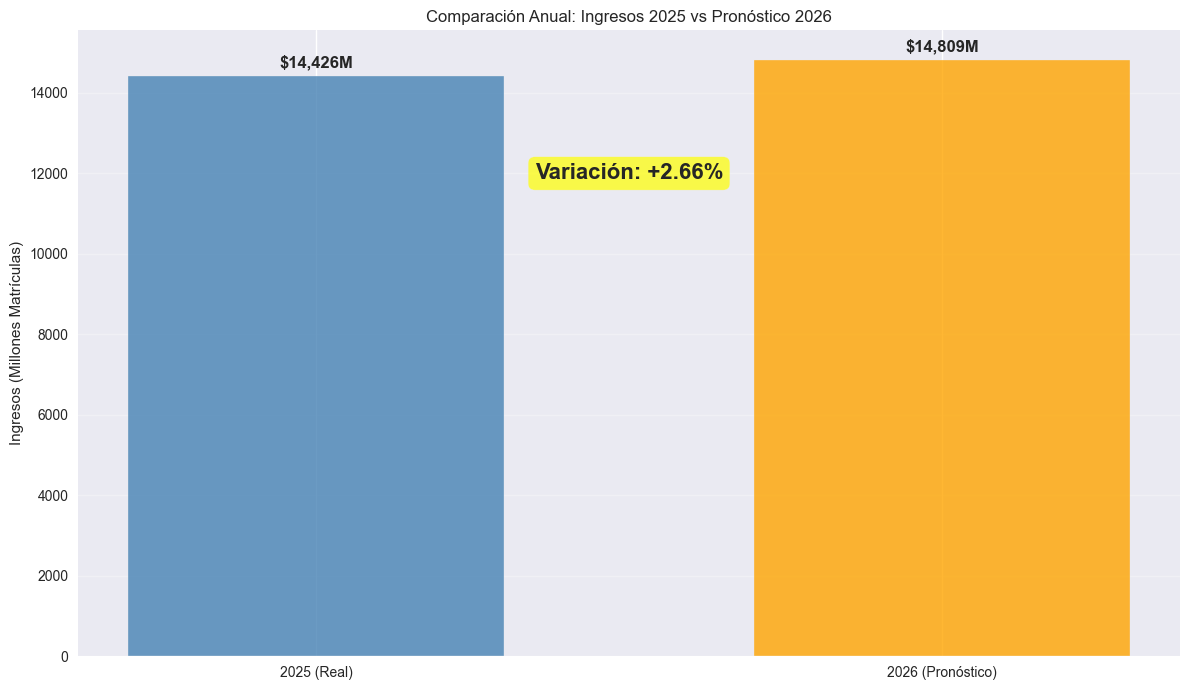

In [22]:
# Crear visualización usando los resultados corregidos
fig, ax = plot_annual_comparison(
    results_dict=results_corrected,
    figsize=(12, 7),
    currency='Matrículas'
)

plt.show()

## Análisis de Variación Porcentual Año a Año

In [23]:
pronostico_auto_arima_x_real

,unique_id,ds,auto,auto-lo-95,auto-lo-90,auto-hi-90,auto-hi-95
0,1,2025-09-30,1304.23,991.66,1036.32,1641.42,1715.34
1,1,2025-10-31,1320.32,997.01,1043.07,1671.27,1748.46
2,1,2025-11-30,1030.47,772.31,808.96,1312.64,1374.93
3,1,2025-12-31,697.67,508.94,535.42,909.09,956.37
4,1,2026-01-31,1418.65,1028.85,1083.39,1857.65,1956.12
5,1,2026-02-28,1307.63,942.63,993.56,1720.99,1813.97
6,1,2026-03-31,1320.71,944.37,996.69,1750.07,1847.04
7,1,2026-04-30,1295.46,922.60,974.34,1722.40,1819.01
8,1,2026-05-31,1212.48,860.50,909.28,1616.79,1708.42
9,1,2026-06-30,1189.79,841.60,889.78,1590.98,1682.05


# Exportar datos 

In [24]:
pronosticos_final = pronostico_auto_arima_x_real.rename(columns= {"ds": "Fecha"})

In [25]:
file_path = export_data(
    data=pronosticos_final,
    filename="Pronostico Matrícula Comerciante",
    output_dir="data/model_outputs",
    file_format="csv",
    add_timestamp=False
)

📁 DATOS EXPORTADOS EXITOSAMENTE
Archivo:     Pronostico Matrícula Comerciante.csv
Directorio:  data/model_outputs
Ruta:        data/model_outputs\Pronostico Matrícula Comerciante.csv
Formato:     CSV
Tamaño:      0.00 MB
Filas:       16
Columnas:    7
Fecha:       2025-10-15 00:57:27
